<a href="../02_LTF/_LTF-Index.ipynb">&larr; LTF-Index </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>

# Abgetastetes und gefiltertes "Sensorsignal" im Frequenzbereich

Notebook / Musterlösung zu Aufgabe "Filterung des Sensorsignals im Frequenzbereich". 

In [16]:
import os, sys
home_dir = os.path.abspath(os.path.join('..'))
if home_dir not in sys.path:  # append directory one level up to import path
    sys.path.append(home_dir) # if it hasn't been appended already
import dsp_fpga_lib as dsp

import numpy as np
from numpy import pi, cos, log10
import scipy.signal as sig

import matplotlib.pyplot as plt
%matplotlib inline
figsize = {"figsize":(11,9)}

In der folgenden Zelle definieren wir das Signal `xn[n]` und das Filter, definiert durch Zählerkoeffizienten `b` und Nennerkoeffizienten `a`. Kommentieren Sie die verschiedenen Filter ein, experimentieren Sie mit Filteroptionen und Signalformen!

In [17]:
Ts = 1/200.0     # sampling period
f1 = 50.0      # signal frequency
phi0  = 0        # signal initial phase
Tmax = 100.0/f1  # time for 6 signal periods
N_Ts = Tmax / Ts # No. of samples in Tmax
# -- Sampled input signal and filter coeffs.
n = np.arange(0,round(N_Ts)) # sample n
xn = 1.5 + 0.5 * cos(2.0 * pi*f1*n*Ts + phi0)
b = np.ones(5)/5; a = 1 # MA-filter
b = np.convolve([1,1,1],[1,1,1]); a = 1
b = [1, 0]; a = [1, -0.9] # lossy integr.
b = [1,2,1]; a = [1]
#N = [1 + 1j, 1 + 1j, 1] # definiere Nullstellen
#b = np.poly(N); a = 1 # und berechnen daraus die Zählerkoeffizienten

Zunächst stellen wir die Impulsantwort `h[n]` dar und berechnen das Ausgangssignal des Filters `y[n]` durch Faltung der Impulsantwort mit dem Eingangssignal. Den komplexen Frequenzsgang `H(f)` berechnen wir mit der Funktion `sig.freqz(b,a)` und stellen dessen Betrag logarithmisch dar.

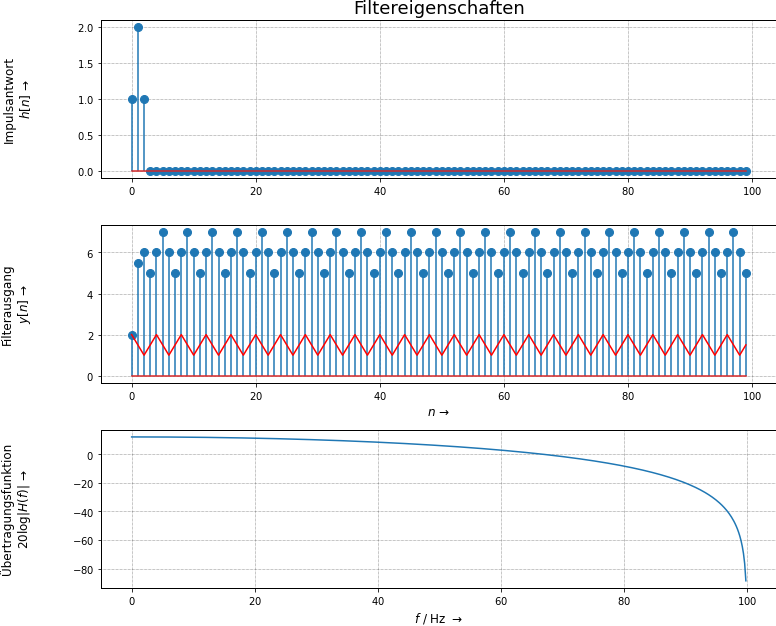

In [18]:
fig1, (ax1,ax2,ax3) = plt.subplots(3,1, **figsize)
h, t = dsp.impz(b,a) # impulse response
ax1.stem(range(len(h)),h, use_line_collection=True)
ax1.grid(True)
ax1.set_ylabel(r'Impulsantwort' '\n' r'$h[n]\, \rightarrow$')
ax1.yaxis.set_label_coords(-0.1, 0.5)
ax1.set_title('Filtereigenschaften', fontsize=18)
#
yn = np.convolve(xn,h) # Faltung (Convolution) von x und h
N_max = min(len(yn), 100) # begrenze Punktezahl auf 100
ax2.grid(True)
ax2.stem(range(N_max),yn[:N_max], use_line_collection=True)
ax2.plot(xn[:N_max],'r')
ax2.set_xlabel(r'$n \, \rightarrow$')
ax2.set_ylabel(r'Filterausgang' '\n' r'$y[n]\, \rightarrow$')
ax2.yaxis.set_label_coords(-0.1, 0.5)
#
w,h = sig.freqz(b,a); f =  w / (2*pi*Ts)
ax3.plot(f, 20*log10(abs(h)))
ax3.set_ylabel(r'Übertragungsfunktion' '\n' r'$20 \log |H(f)|\, \rightarrow$')
ax3.set_xlabel(r'$f$ / Hz $\rightarrow$')
ax3.yaxis.set_label_coords(-0.1, 0.5)
ax3.grid(True)
#
fig1.set_tight_layout(True)

Den komplexen Frequenzsgang `H(f) = sig.freqz(b,a)` normieren wir hier auf den maximalen Betrag, um die Unterdrückung des Störsignals leicht ablesen zu können. Daraus leiten wir Betragsgang `abs(H)` und Phasengang `angle(H)` ab. Für die Gruppenlaufzeit gibt es eine eigene Funktion `sig.group_delay((b,a))`. Wichtig: die Koeffizienten müssen als Tuple `(b,a)` übergeben werden.

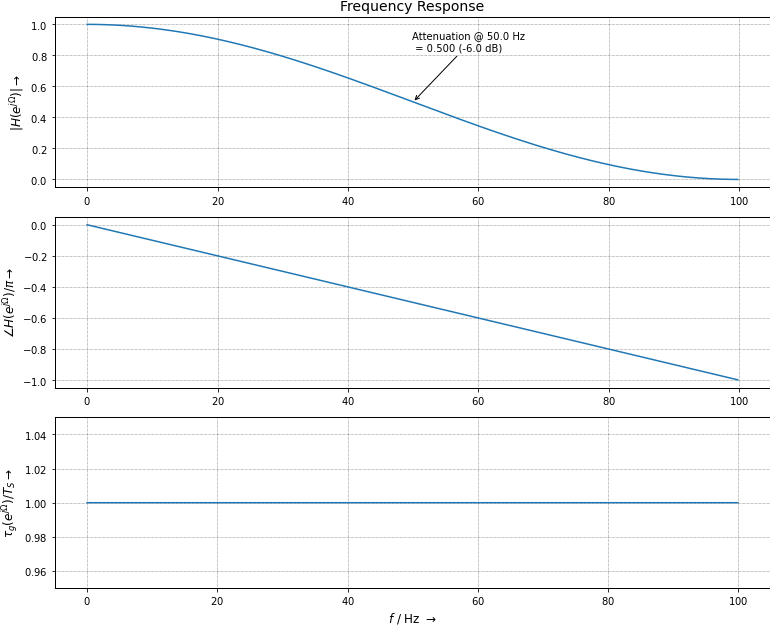

In [19]:
# ----- frequency response -----
fig2, (ax21,ax22,ax23) = plt.subplots(3,1, **figsize)
[W, H] = sig.freqz(b, a, whole=0);
f = W  / (Ts * 2 * pi)
(w,Asig) = sig.freqz(b,a, f1*Ts*2*pi)
H_mx = np.max(abs(H))
H = H / H_mx; Asig = abs(Asig)/H_mx
#
ax21.plot(f,abs(H))
ax21.set_ylabel(r'$|H(e^{j \Omega})| \rightarrow$')
ax21.set_title('Frequency Response')
ax21.annotate('Attenuation @ %.1f Hz \n = %1.3f (%3.1f dB)'%(f1,Asig,20*log10(Asig)),\
(f1, Asig),(0.5,0.8),textcoords='axes fraction', arrowprops=dict(arrowstyle="->"))
#
ax22.plot(f, np.angle(H)/pi)
ax22.set_ylabel(r'$\angle H(e^{j\Omega}) / \pi \rightarrow $')
#
#tau, w = dsp.grpdelay(b,a, nfft = 2048, Fs = 200, whole=0)
w, tau = sig.group_delay((b,a), w=2048, fs=200, whole=False)
ax23.plot(w, tau)
ymin, ymax = ax23.get_ylim(); dy = max(ymax - ymin, 1) * 0.05
ax23.set_ylim(ymin - dy, ymax + dy) # set reasonable range
ax23.set_xlabel(r'$f$ / Hz $\rightarrow$')
ax23.set_ylabel(r'$\tau_g(e^{j \Omega}) / T_S \rightarrow$')
fig2.set_tight_layout(True)

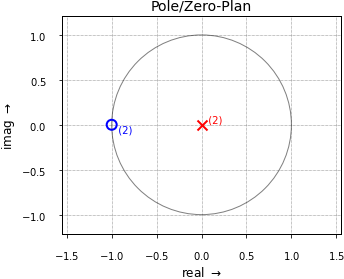

In [20]:
# ----- P/Z-Plot -----
fig3, ax1 = plt.subplots(1, figsize=(5,4)) # erzeuge nur einen Subplot
ax1.grid(True)
ax1.set_title('Pole/Zero-Plan')
ax1.set_xlabel(r'real $\rightarrow$')
ax1.set_ylabel(r'imag $\rightarrow$')
dsp.zplane(b,a);

### Aufgaben und Experimente
Da dies ohnehin schon eine Musterlösung ist, besteht Ihre Aufgabe hier nur darin, den Code nachzuvollziehen und verschiedene Filter auszuprobieren.

***
### Copyright

(c) 2016 - 2020 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.